**Introduction**
* **Natural Language Processing (NLP):** The discipline of computer science, artificial intelligence and linguistics that is concerned with the creation of computational models that process and understand natural language. These include: making the computer understand the semantic grouping of words (e.g. cat and dog are semantically more similar than cat and spoon), text to speech, language translation and many more

* **Sentiment Analysis:** It is the interpretation and classification of emotions (positive, negative and neutral) within text data using text analysis techniques. Sentiment analysis allows organizations to identify public sentiment towards certain words or topics.

# **Import Packages**

In [ ]:
import numpy as np
import pandas as pd


#Plotting 
import matplotlib.pyplot as plt 

#reading dataset
import pandas as pd

#nltk , data processing 
import nltk 
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

#Removing, data processing
import re

# data processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.text import Tokenizer

# Network 
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
import tensorflow as tf

from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,  classification_report


# **Driver**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Some Functions**

In [ ]:
def plothist(hist):
    plt.plot(hist.history['accuracy'],color='b',linewidth=2.0)
    plt.plot(hist.history['val_accuracy'],color='r',linewidth=2.0)

    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.grid()
    plt.show()

def plothist_loss(hist):
    plt.plot(hist.history['loss'],color='b',linewidth=2.0)
    plt.plot(hist.history['val_loss'],color='r',linewidth=2.0)
  
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.grid()
    plt.show()

# **Import Dataset**

The dataset being used is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the Twitter API. The tweets have been annotated (0 = Negative, 4 = Positive) and they can be used to detect sentiment.

[The training data isn't perfectly categorised as it has been created by tagging the text according to the emoji present. So, any model built using this dataset may have lower than expected accuracy, since the dataset isn't perfectly categorised.]

It contains the following 6 fields:

* sentiment: the polarity of the tweet (0 = negative, 4 = positive)
* ids: The id of the tweet (2087)
* date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* query: The query (lyx). If there is no query, then this value is NO_QUERY.
* user: the user that tweeted (robotickilldozr)
* text: the text of the tweet (Lyx is cool)
We require only the sentiment and text fields, so we discard the rest.

Furthermore, we're changing the sentiment field so that it has new values to reflect the sentiment. **(0 = Negative, 1=neutral 2 = Positive)**

In [ ]:
# Read in data into a dataframe
cols = ['sentiment', 'id', 'date', 'query', 'user_name', 'text']
df = pd.read_csv('/content/drive/MyDrive/Dataset/Sentiment Analysis/training.1600000.processed.noemoticon.csv', header=None, names=cols,encoding='latin-1')
df.head(5)


,sentiment,id,date,query,user_name,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


# **Preparing Dataset**

**Preprocess Text**

Text Preprocessing is traditionally an important step for Natural Language Processing (NLP) tasks. It transforms text into a more digestible form so that machine learning algorithms can perform better.

The Preprocessing steps taken are:

* Lower Casing: Each text is converted to lowercase.
* Replacing or removing URLs: Links starting with "http" or "https" or "www" are replaced by "URL" or removing them.
* Replacing Emojis: Replace emojis by using a pre-defined dictionary containing emojis along with their meaning. (eg: ":)" to "EMOJIsmile")
* Replacing Usernames: Replace @Usernames with word "USER". (eg: "@Kaggle" to "USER")
* Removing Non-Alphabets: Replacing characters except Digits and Alphabets with a space.
* Removing Consecutive letters: 3 or more consecutive letters are replaced by 2 letters. (eg: "Heyyyy" to "Heyy")
* Removing Stopwords: Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. (eg: "the", "he", "have")


In [ ]:
# Removing the unnecessary columns.
df = df.drop(['id', 'date', 'query', 'user_name'], axis=1)
df.head(5)

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [ ]:
# Change labels [0:negative , 1:neutral , 2: positive]
label_to_sentiment = {0:0, 2:1 , 4:2}
def mapper(label):
     return label_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: mapper(x))

In [ ]:
# Import nltk package and download the stopwords
nltk.download('stopwords')
# We filter out the english language stopwrds
stop_words = stopwords.words('english')
print(stop_words)

stemmer = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'ea

In [ ]:
# Remoning some usless information in the text
text_cleaning_regex = "@S+|https?:S+|http?:S|[^A-Za-z0-9]+"

In [ ]:
def clean_tweets(text, stem=False):
  # Text passed to the regex equatio
  text = re.sub(text_cleaning_regex, ' ', str(text).lower()).strip()
  # Empty list created to store final tokens
  tokens = []
  for token in text.split():
    # check if the token is a stop word or not
    if token not in stop_words:
      if stem:
        # Paased to the snowball stemmer
        tokens.append(stemmer.stem(token))
      else:
        # A
        tokens.append(token)
  return " ".join(tokens)

In [ ]:
df.text = df.text.apply(lambda x: clean_tweets(x))

# **Splitting dataset**

In [ ]:
# Splitting the data into training and testing sets
(train_data, valid_data) = train_test_split(df, test_size=0.2,random_state=16)
print("Train Data size:", len(train_data))
print("Valid Data size", len(valid_data))

Train Data size: 1280000
Valid Data size 320000


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 565660


In [ ]:
# The tokens are converted into sequences and then passed to the pad_sequences() function
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),maxlen = 30)
x_valid = pad_sequences(tokenizer.texts_to_sequences(valid_data.text),maxlen = 30)

encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())
y_train = encoder.transform(train_data.sentiment.to_list())
y_valid = encoder.transform(valid_data.sentiment.to_list())


y_train = y_train.reshape(-1,1)
y_valid = y_valid.reshape(-1,1)


# **Word Embedding,One Hot,golve42b**

In [ ]:
#one_hot
y_train = np_utils.to_categorical(y_train, 2)
y_valid = np_utils.to_categorical(y_valid, 2)
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(1280000, 30)
(1280000, 2)
(320000, 30)
(320000, 2)


In [ ]:
!wget http://nlp.stanford.edu/data/glove.42B.300d.zip

--2022-01-04 08:50:24--  http://nlp.stanford.edu/data/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.42B.300d.zip [following]
--2022-01-04 08:50:25--  https://nlp.stanford.edu/data/glove.42B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip [following]
--2022-01-04 08:50:25--  http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877800501 (1.7G) [application/zip]
Sav

In [ ]:
# Using golve42b after 300
!unzip /content/glove.42B.300d.zip

Archive:  /content/glove.42B.300d.zip
  inflating: glove.42B.300d.txt      


In [ ]:
embeddings_index = {}
# opening the downloaded glove embeddings file
f = open('/content/glove.42B.300d.txt')
for line in f:
    # For each line file, the words are split and stored in a list
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' %len(embeddings_index))

Found 1917494 word vectors.


In [ ]:
# creating an matrix with zeroes of shape vocab x embedding dimension
embedding_matrix = np.zeros((vocab_size, 300))
# Iterate through word, index in the dictionary
for word, i in word_index.items():
    # extract the corresponding vector for the vocab indice of same word
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Storing it in a matrix
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,300,weights=[embedding_matrix],
                                          input_length=30,trainable=False)


# **Test Data**

In [ ]:
# test data
df_test = pd.read_csv('/content/drive/MyDrive/Dataset/Sentiment Analysis/testdata.manual.2009.06.14.csv', header=None, names=cols,encoding='latin-1')
df_test.head(5)

,sentiment,id,date,query,user_name,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [ ]:
df_test = df_test.drop(['id', 'date', 'query', 'user_name'], axis=1)
df_test.head(5)


,sentiment,text
0,4,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,Reading my kindle2... Love it... Lee childs i...
2,4,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,@kenburbary You'll love your Kindle2. I've had...
4,4,@mikefish Fair enough. But i have the Kindle2...


In [ ]:
df_test.sentiment = df_test.sentiment.apply(lambda x: mapper(x))


In [ ]:
df_test.sentiment

0      2
1      2
2      2
3      2
4      2
      ..
493    1
494    0
495    2
496    0
497    0
Name: sentiment, Length: 498, dtype: int64

In [ ]:
df_test=df_test.drop(df_test[df_test["sentiment"]==1].index)

In [ ]:
df_test.sentiment

0      2
1      2
2      2
3      2
4      2
      ..
492    2
494    0
495    2
496    0
497    0
Name: sentiment, Length: 359, dtype: int64

In [ ]:
df_test.text = df_test.text.apply(lambda x: clean_tweets(x))

In [ ]:
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text),maxlen = 30)

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_test.sentiment.to_list())

y_test = encoder.transform(df_test.sentiment.to_list())
y_test = y_test.reshape(-1,1)
y_test = np_utils.to_categorical(y_test, 2)

In [ ]:
print(x_test.shape)
print(y_test.shape)

(359, 30)
(359, 2)


# **a. LSTM**


**Parameters and Hyper-Parameters**
* 	Batch Size: 1024
* 	Epochs: 20
* 	Number of Neurons in hidden layers:150
* 	Number of Neurons in output layer:3
* 	Hidden Layer Activation Function: -
* 	Output Layer Activation Function: Softmax
* 	Loss Function: Categorical_Crossentropy
* 	Optimizer: ADAM
* 	Dropout: 0.2












In [ ]:
# The Input layer 
sequence_input = Input(shape=(30,), dtype='int32')
# Inputs passed to the embedding layer
embedding_sequences = embedding_layer(sequence_input)
# dropout and conv layer 
x = Dropout(0.2)(embedding_sequences)
#x = Conv1D(150, 5, activation='relu')(x)
# Passed on to the LSTM layer
x = LSTM(150, dropout=0.2, recurrent_dropout=0.2)(x)
#x = Dense(512, activation='relu')(x)
#x = Dropout(0.5)(x)
#x = Dense(512, activation='relu')(x)
# Passed on to activation layer to get final output
outputs = Dense(2, activation='softmax')(x)
model = tf.keras.Model(sequence_input, outputs)

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=1024, epochs=20, validation_data=(x_valid, y_valid),verbose = 1)


Epoch 1/20
1250/1250 [==============================] - 242s 190ms/step - loss: 0.4953 - accuracy: 0.7562 - val_loss: 0.4599 - val_accuracy: 0.7802
Epoch 2/20
1250/1250 [==============================] - 231s 185ms/step - loss: 0.4626 - accuracy: 0.7783 - val_loss: 0.4465 - val_accuracy: 0.7886
Epoch 3/20
1250/1250 [==============================] - 232s 185ms/step - loss: 0.4515 - accuracy: 0.7851 - val_loss: 0.4426 - val_accuracy: 0.7908
Epoch 4/20
1250/1250 [==============================] - 231s 185ms/step - loss: 0.4447 - accuracy: 0.7894 - val_loss: 0.4376 - val_accuracy: 0.7938
Epoch 5/20
1250/1250 [==============================] - 232s 185ms/step - loss: 0.4396 - accuracy: 0.7925 - val_loss: 0.4340 - val_accuracy: 0.7963
Epoch 6/20
1250/1250 [==============================] - 232s 185ms/step - loss: 0.4356 - accuracy: 0.7946 - val_loss: 0.4341 - val_accuracy: 0.7969
Epoch 7/20
1250/1250 [==============================] - 238s 190ms/step - loss: 0.4328 - accuracy: 0.7965 - val_

In [ ]:
# Evaluation on the training
print('Evaluation with Test Set:')
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test acc:', acc)

Evaluation with Test Set:
Test loss: 0.37673869729042053
Test acc: 0.8328690528869629


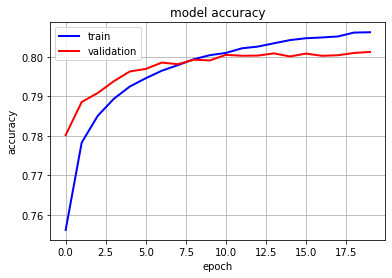

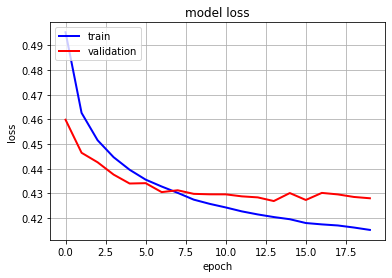

In [ ]:
plothist(history)
plothist_loss(history)

### **Confusion Matrix and Error**

Text(0.5, 1.0, 'Refined Confusion Matrix')

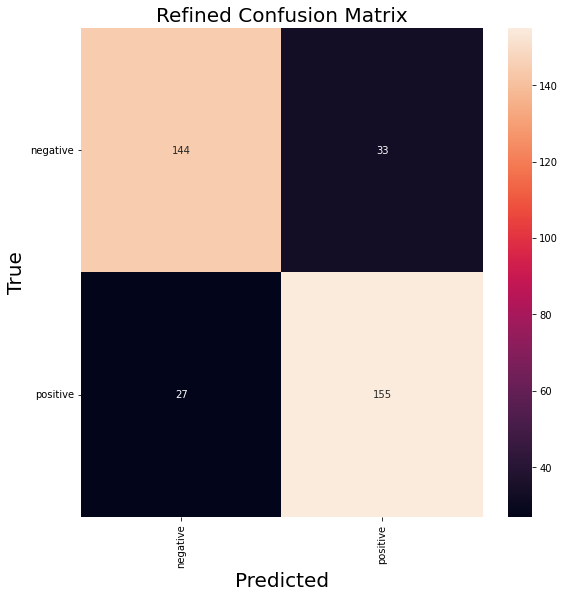

In [ ]:
y_pred=model.predict(x_test) 

y_pred=np.argmax(y_pred, axis=1)
y_test_cm=np.argmax(y_test, axis=1)


cm = confusion_matrix(y_test_cm, y_pred)
labels=['negative' , 'positive']
# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(9, 9))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(labels, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(labels, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

In [ ]:
print(classification_report(y_test_cm, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.81      0.83       177
           1       0.82      0.85      0.84       182

    accuracy                           0.83       359
   macro avg       0.83      0.83      0.83       359
weighted avg       0.83      0.83      0.83       359



# **b. Bio-LSTM**


**Parameters and Hyper-Parameters**
* 	Batch Size: 1024
* 	Epochs: 20
* 	Number of Neurons in hidden layers:150
* 	Number of Neurons in output layer:3
* 	Hidden Layer Activation Function: -
* 	Output Layer Activation Function: Softmax
* 	Loss Function: Categorical_Crossentropy
* 	Optimizer: ADAM
* 	Dropout: 0.2












In [ ]:
sequence_input = Input(shape=(30,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Bidirectional(LSTM(150, dropout=0.2, recurrent_dropout=0.2))(x)
outputs = Dense(2, activation='softmax')(x)
model = tf.keras.Model(sequence_input, outputs)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_bilstm = model.fit(x_train, y_train, batch_size=1024, epochs=20, validation_data=(x_valid, y_valid))
# Evaluation on the training
print('Evaluation with Test Set:')
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test acc:', acc)


Epoch 1/20
1250/1250 [==============================] - 468s 371ms/step - loss: 0.4942 - accuracy: 0.7569 - val_loss: 0.4582 - val_accuracy: 0.7808
Epoch 2/20
1250/1250 [==============================] - 463s 370ms/step - loss: 0.4614 - accuracy: 0.7792 - val_loss: 0.4461 - val_accuracy: 0.7895
Epoch 3/20
1250/1250 [==============================] - 462s 370ms/step - loss: 0.4495 - accuracy: 0.7866 - val_loss: 0.4489 - val_accuracy: 0.7864
Epoch 4/20
1250/1250 [==============================] - 450s 360ms/step - loss: 0.4408 - accuracy: 0.7918 - val_loss: 0.4341 - val_accuracy: 0.7960
Epoch 5/20
1250/1250 [==============================] - 463s 371ms/step - loss: 0.4346 - accuracy: 0.7952 - val_loss: 0.4341 - val_accuracy: 0.7973
Epoch 6/20
1250/1250 [==============================] - 449s 360ms/step - loss: 0.4298 - accuracy: 0.7979 - val_loss: 0.4350 - val_accuracy: 0.7962
Epoch 7/20
1250/1250 [==============================] - 463s 370ms/step - loss: 0.4254 - accuracy: 0.8007 - val_

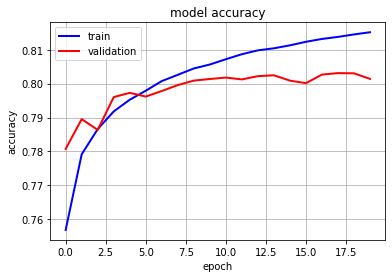

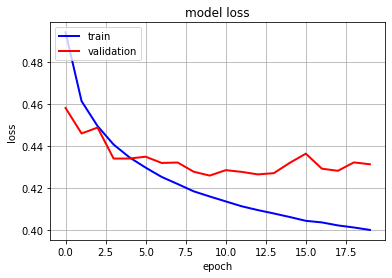

In [ ]:
plothist(history_bilstm)
plothist_loss(history_bilstm)

### **Confusion Matrix and Error**

Text(0.5, 1.0, 'Refined Confusion Matrix')

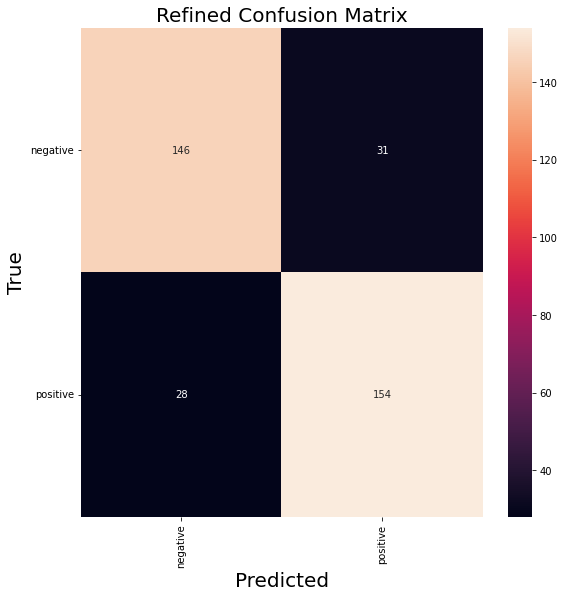

In [ ]:
y_pred=model.predict(x_test) 

y_pred=np.argmax(y_pred, axis=1)
y_test_cm=np.argmax(y_test, axis=1)


cm = confusion_matrix(y_test_cm, y_pred)
labels=['negative' , 'positive']
# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(9, 9))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(labels, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(labels, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

In [ ]:
print(classification_report(y_test_cm, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       177
           1       0.83      0.85      0.84       182

    accuracy                           0.84       359
   macro avg       0.84      0.84      0.84       359
weighted avg       0.84      0.84      0.84       359



# **c. Pyramid LSTM**


**Parameters and Hyper-Parameters**
* 	Batch Size: 1024
* 	Epochs: 20
* 	Number of Level:4
*   Size of Hidden Layer: 64,32,16,8
* 	Hidden Layer Activation Function: ReLU
* 	Output Layer Activation Function: Softmax
* 	Loss Function: Categorical_Crossentropy
* 	Optimizer: ADAM
* 	Dropout: 0.2












In [ ]:
class pBLSTM(tf.keras.layers.Layer):
  def __init__(self, dim):
    super(pBLSTM, self).__init__()
    
    self.dim        = dim
    self.LSTM       = tf.keras.layers.LSTM(self.dim, return_sequences=True)
    self.bidi_LSTM  = tf.keras.layers.Bidirectional(self.LSTM)
    
  @tf.function
  def call(self, inputs):
    y = self.bidi_LSTM(inputs) # (..., seq_len, 2*dim)
    
    if tf.shape(inputs)[1] % 2 == 1:
      y = tf.keras.layers.ZeroPadding1D(padding=(0, 1))(y)

    y = tf.keras.layers.Reshape(target_shape=(-1, int(self.dim*2)))(y) # (..., seq_len//2, 4*dim)
    return y


In [ ]:
def define_model_py():
  embedding_layer = tf.keras.layers.Embedding(vocab_size,300,weights=[embedding_matrix],
                                          input_length=30,trainable=False)
  sequence_input = Input(shape=(30,), dtype='int32')
  embedding_sequences = embedding_layer(sequence_input)
  x = Dropout(0.2)(embedding_sequences)
  x=pBLSTM(64)(x)
  x=pBLSTM(32)(x)
  x=pBLSTM(16)(x)
  x=Bidirectional(LSTM(8))(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.5)(x)
  outputs = Dense(2, activation='softmax')(x)
  model=tf.keras.Model(sequence_input,outputs)
  return model

In [ ]:
model_py=define_model_py()

In [ ]:
model_py.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history_py= model_py.fit(x_train, y_train, batch_size=1024, epochs=20, validation_data=(x_valid, y_valid))

Epoch 1/20
1250/1250 [==============================] - 204s 155ms/step - loss: 0.4872 - accuracy: 0.7621 - val_loss: 0.4562 - val_accuracy: 0.7823
Epoch 2/20
1250/1250 [==============================] - 193s 154ms/step - loss: 0.4550 - accuracy: 0.7837 - val_loss: 0.4464 - val_accuracy: 0.7889
Epoch 3/20
1250/1250 [==============================] - 192s 154ms/step - loss: 0.4434 - accuracy: 0.7902 - val_loss: 0.4395 - val_accuracy: 0.7933
Epoch 4/20
1250/1250 [==============================] - 193s 154ms/step - loss: 0.4353 - accuracy: 0.7950 - val_loss: 0.4340 - val_accuracy: 0.7960
Epoch 5/20
1250/1250 [==============================] - 192s 154ms/step - loss: 0.4298 - accuracy: 0.7985 - val_loss: 0.4334 - val_accuracy: 0.7980
Epoch 6/20
1250/1250 [==============================] - 193s 154ms/step - loss: 0.4242 - accuracy: 0.8016 - val_loss: 0.4342 - val_accuracy: 0.7977
Epoch 7/20
1250/1250 [==============================] - 193s 154ms/step - loss: 0.4201 - accuracy: 0.8038 - val_

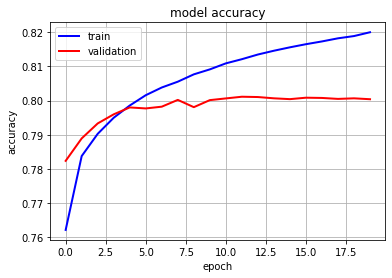

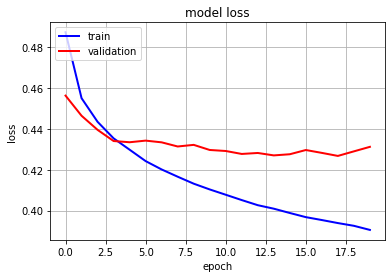

In [ ]:
plothist(history_py)
plothist_loss(history_py)

Text(0.5, 1.0, 'Refined Confusion Matrix')

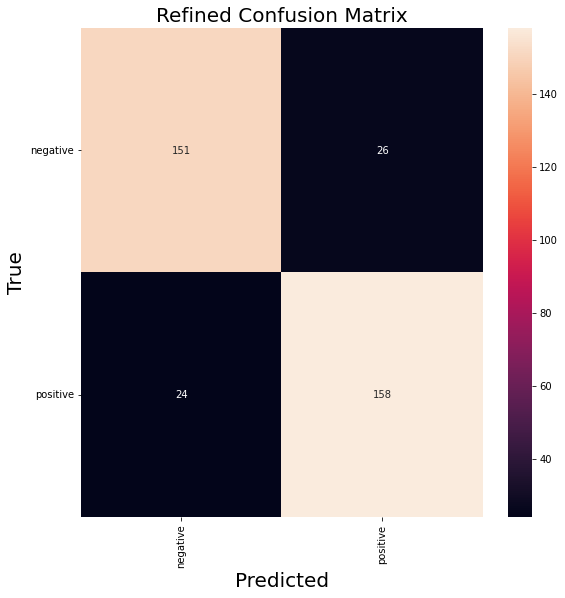

In [ ]:
y_pred=model_py.predict(x_test) 

y_pred=np.argmax(y_pred, axis=1)
y_test_cm=np.argmax(y_test, axis=1)


cm = confusion_matrix(y_test_cm, y_pred)
labels=['negative' , 'positive']
# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(9, 9))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(labels, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(labels, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

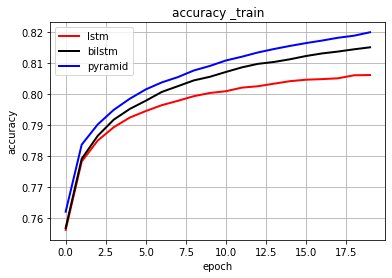

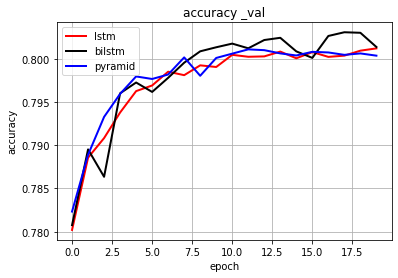

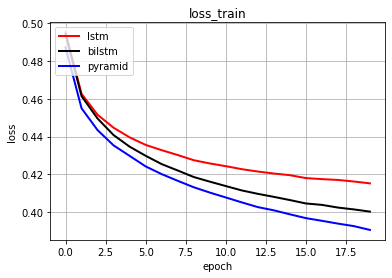

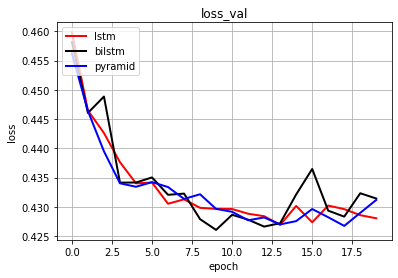

In [ ]:
plt.plot(history.history['accuracy'],color='r',lw=2.0)
plt.plot(history_bilstm.history['accuracy'],color='k',lw=2.0)
plt.plot(history_py.history['accuracy'],color='b',lw=2.0)

plt.title('accuracy _train')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['lstm', 'bilstm','pyramid'], loc='upper left')
plt.grid()
plt.show()

plt.plot(history.history['val_accuracy'],color='r',lw=2.0)
plt.plot(history_bilstm.history['val_accuracy'],color='k',lw=2.0)
plt.plot(history_py.history['val_accuracy'],color='b',lw=2.0)

plt.title('accuracy _val')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['lstm', 'bilstm','pyramid'], loc='upper left')
plt.grid()
plt.show()

plt.plot(history.history['loss'],color='r',lw=2.0)
plt.plot(history_bilstm.history['loss'],color='k',lw=2.0)
plt.plot(history_py.history['loss'],color='b',lw=2.0)
plt.title('loss_train')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['lstm', 'bilstm','pyramid'], loc='upper left')
plt.grid()
plt.show()

plt.plot(history.history['val_loss'],color='r',lw=2.0)
plt.plot(history_bilstm.history['val_loss'],color='k',lw=2.0)
plt.plot(history_py.history['val_loss'],color='b',lw=2.0)
plt.title('loss_val')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['lstm', 'bilstm','pyramid'], loc='upper left')
plt.grid()
plt.show()

# **d. BERT**

## **Load RoBERTa**

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 4.7 MB/s 
     |████████████████████████████████| 895 kB 37.1 MB/s 
     |████████████████████████████████| 596 kB 46.7 MB/s 
     |████████████████████████████████| 3.3 MB 44.5 MB/s 
     |████████████████████████████████| 59 kB 6.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# importing libraries for neural network
import torch
from transformers import RobertaModel

In [ ]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.classifier = torch.nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, 
                           attention_mask=attention_mask, 
                           token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        output = self.classifier(pooler)
        return output

In [ ]:
model = RobertaClass()
model.to(device)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), e

## **Load data**

In [ ]:
from google.colab import drive
# connect with your google drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
import pandas as pd
# paste your path to the dataset
!cp '/content/drive/MyDrive/Colab Notebooks/BroutonLab/Article/dataset.zip' dataset.zip

In [ ]:
# unzip files from archive
import zipfile
with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("./")

## **Prepare data**

In [ ]:
# drop unnecessary columns and rename the remaining ones
full_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', 
                        encoding='latin-1').drop(["1467810369",
                                                  "Mon Apr 06 22:19:45 PDT 2009",
                                                  "NO_QUERY","_TheSpecialOne_"],
                                                 axis=1).dropna()
columns_names = list(full_data)
full_data.rename(columns={columns_names[0]:"label",
                        columns_names[1]:"text"}, inplace= True)

In [ ]:
NUM_SAMPLES = 30000
# separate the positive and negative tweets and take NUM_SAMPLES from them
negative_samples = full_data[full_data["label"]==0][:NUM_SAMPLES]
positiv_samples = full_data[full_data["label"]==4][:NUM_SAMPLES]

In [ ]:
# replace label 4 with label 1 because the neural network outputs only 0 or 1
positiv_samples["label"]=[1]*NUM_SAMPLES

In [ ]:
# concat back to one dataset
full_data = pd.concat([negative_samples,  positiv_samples])

In [ ]:
full_data

,label,text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew
...,...,...
829994,1,"Really wants to go and see 17 again, because Z..."
829995,1,@krissa22 Thank you!
829996,1,dreaming of you
829997,1,@TheEllenShow I saw a clip online! good show!


In [ ]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(full_data, test_size=0.3)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# information about dataset
print("FULL Dataset: {}".format(full_data.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))



FULL Dataset: (60000, 2)
TRAIN Dataset: (42000, 2)
TEST Dataset: (18000, 2)


In [ ]:
from transformers import RobertaTokenizer

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', 
                                             truncation=True, 
                                             do_lower_case=True)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [ ]:
MAX_LEN = 130
train_tokenized_data = [tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=MAX_LEN,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        for text in train_data['text']]
test_tokenized_data = [tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=MAX_LEN,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        for text in test_data['text']]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## **Prepare dataset**

In [ ]:
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32      
LEARNING_RATE = 1e-05

In [ ]:
from torch.utils.data import Dataset, DataLoader

class SentimentData(Dataset):
    def __init__(self, data, inputs_tokenized):
        self.inputs = inputs_tokenized
        self.text = data['text']
        self.targets = data['label']

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())
        
        input = self.inputs[index]
        ids = input['input_ids']
        mask = input['attention_mask']
        token_type_ids = input['token_type_ids']

        return {
            'sentence': text,
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

train_dataset = SentimentData(train_data, train_tokenized_data)
test_dataset = SentimentData(test_data, test_tokenized_data)

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True
                }

test_params = {'batch_size': TEST_BATCH_SIZE,
                'shuffle': True
                }

train_loader = DataLoader(train_dataset, **train_params)
test_loader = DataLoader(test_dataset, **test_params)

## **Fine-tuning model**

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

train_loss = []
test_loss = []

train_accuracy = []
test_accuracy = []

test_answers = [[[],[]], [[],[]]]

def train_loop(epochs):
  for epoch in range(epochs):
    for phase in ['Train', 'Test']:
      if(phase == 'Train'):
        model.train()
        loader = train_loader
      else:
        model.eval()
        loader = test_loader  
      epoch_loss = 0
      epoch_acc = 0
      for steps, data in tqdm(enumerate(loader, 0)):
        sentence = data['sentence']
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model.forward(ids, mask, token_type_ids)

        loss = loss_function(outputs, targets)        
        
        epoch_loss += loss.detach()
        _, max_indices = torch.max(outputs.data, dim=1)
        bath_acc = (max_indices==targets).sum().item()/targets.size(0)
        epoch_acc += bath_acc

        if (phase == 'Train'):
          train_loss.append(loss.detach()) 
          train_accuracy.append(bath_acc)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
        else:
          test_loss.append(loss.detach()) 
          test_accuracy.append(bath_acc)
          if epoch == epochs-1:
            for i in range(len(targets)):
              test_answers[targets[i].item()][max_indices[i].item()].append([sentence[i], 
                                                                 targets[i].item(), 
                                                                 max_indices[i].item()])

      print(f"{phase} Loss: {epoch_loss/steps}")
      print(f"{phase} Accuracy: {epoch_acc/steps}")

In [ ]:
EPOCHS = 4
train_loop(EPOCHS)

1313it [27:45,  1.27s/it]


Train Loss: 0.37769362330436707
Train Accuracy: 0.8323170731707317


563it [04:25,  2.12it/s]


Test Loss: 0.30662792921066284
Test Accuracy: 0.8734986654804271


1313it [27:44,  1.27s/it]


Train Loss: 0.2858887314796448
Train Accuracy: 0.8824552210365854


563it [04:25,  2.12it/s]


Test Loss: 0.3246062994003296
Test Accuracy: 0.8694951067615658


1313it [27:44,  1.27s/it]


Train Loss: 0.23274224996566772
Train Accuracy: 0.9074885670731707


563it [04:25,  2.12it/s]


Test Loss: 0.31412824988365173
Test Accuracy: 0.8787811387900356


1313it [27:45,  1.27s/it]


Train Loss: 0.18700234591960907
Train Accuracy: 0.928734756097561


563it [04:26,  2.11it/s]

Test Loss: 0.3407975733280182
Test Accuracy: 0.8727201957295374


## **Visualizing sentiment analysis**

In [ ]:
print('False Negative:\n', test_answers[1][0][0], "\n", test_answers[1][0][1], "\n", test_answers[1][0][2], "\n",
      '\nFalse Positive:\n', test_answers[0][1][0], '\n', test_answers[0][1][1], '\n', test_answers[0][1][2], '\n')

False Negative:
 ['Searching for a good simple RNG, came across really old Usenet postings. People were real assholes back then', 1, 0] 
 ["@_ophelia danny wasn't there just angela, craig and Robert!! Was a great day though", 1, 0] 
 ["#mmuk09 lots of interesting conversations over the lunch break. now, where's @andyramsden ?!", 1, 0] 
 
False Positive:
 ['@AllyAyr Although, Menthol Cigs are vile also.', 0, 1] 
 ['@jacvanek are you a superpupermegaovermodel? sorry idk precisely but thank you for adding me here and on myspace ;P', 0, 1] 
 ['@mojojuju , walk, stumble, curse your way outside, down the driveway, past the chicken coup, keep going, almost there. Outhouse...', 0, 1] 



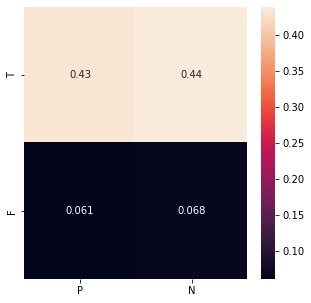

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

len_num = len(test_dataset)

tp=len(test_answers[1][1])/len_num
fn=len(test_answers[1][0])/len_num
fp=len(test_answers[0][1])/len_num
tn=len(test_answers[0][0])/len_num

array_matrix = [[tp,tn], 
                [fp,fn]]
df_cm = pd.DataFrame(array_matrix, index = ['T', 'F'],
                  columns = ['P', 'N'])
plt.figure(figsize = (5,5))
sn.heatmap(df_cm, annot=True)

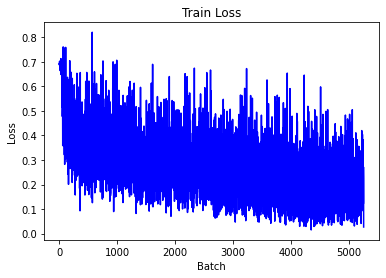

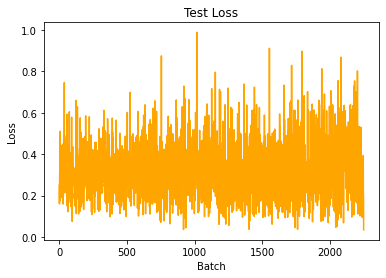

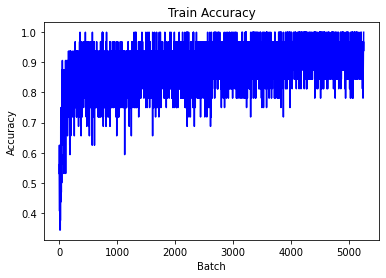

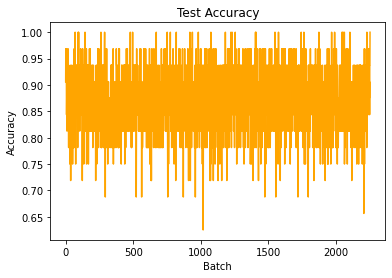

In [ ]:
plt.plot(train_loss,  color='blue')
plt.title("Train Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

plt.plot(test_loss,  color='orange')
plt.title("Test Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")      
plt.show()

plt.plot(train_accuracy,  color='blue')
plt.title("Train Accuracy")
plt.xlabel("Batch")
plt.ylabel("Accuracy")  
plt.show()

plt.plot(test_accuracy,  color='orange')
plt.title("Test Accuracy")
plt.xlabel("Batch")
plt.ylabel("Accuracy")  
 
plt.show()